# Setup

In [1]:
def colab_setup(is_colab=False):
    "Run if using Google Colab"
    if is_colab:
        from google.colab import drive
        drive.mount('/content/drive')
        %cd /content/drive/MyDrive/M4R/Homophily_Analysis/Homophily_Analysis
        import torch
        %pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
        %pip install torch-geometric==2.1.0
        %pip install dive-into-graphs
        %pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html
    return

In [3]:
colab_setup(is_colab=True)

Mounted at /content/drive
/content/drive/MyDrive/M4R/Homophily_Analysis/Homophily_Analysis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 8.9 MB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 5.1 MB/s 
Reason for being yanked: Missing ninja templates
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0-py3-none-any.whl size=687168 sha256=125c435e420218d72a446abdc1ecea043340c3e6f972a9ac29247b4231fdd631
  Stored in directory: /root/.cache/pip/wheels/b8/42/3b/f4d1f1af88f63d529956aa312800905225983a7aab403dd0d3
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 239.2 MB 47 kB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 280 kB 10.5 MB/s 
     |████████████████████████████████| 103 kB 86.5 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 109 kB 76.2 MB/s 
     |████████████████████████████████| 52 kB 41 kB/s 
     |████████████████████████████████| 41 kB 291 kB/s 
     |████████████████████████████████| 3.2 MB 72.0 MB/s 
     |████████████████████████████████| 555 kB 67.6 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 82.1 MB/s 
     |████████████████████████████████| 121 kB 82.9 MB/s 
     |████████████████████████████████| 133 kB 

In [4]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pandas as pd
import torch_geometric
import warnings
from tqdm import tqdm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
warnings.simplefilter("ignore")
import dgl.data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


# Datasets

In [5]:
def relable(labels):
  """
  Relable graph labels uniquely as increasing integers
  Args:
    labels: torch tensor of labels
  Returns:
    relabled labels
  """
  new_l = 0
  new_labels = -1*torch.ones(labels.shape[0])
  for i,l in enumerate(labels):
    if new_labels[i]==-1:
      new_labels[labels==l]=new_l
      new_l +=1
  return new_labels.long()


def pyg_to_dgl_graph_converter(pyg_g):
  """
  Convert a pytorch geometric graph to a dgl graph
  Args:
    pyg_g: pytorch geometric graph
  Returns:
    dgl graph
  """
  u,v = pyg_g.edge_index
  f = pyg_g.x
  labels = pyg_g.y
  g = dgl.graph((u,v))
  g.ndata['feat'] = f
  g.ndata['label'] = relable(labels)
  return g


def add_train_val_test_masks(g):
  """ 
  Add train, val, test masks to graph for the purpose of training a classifier
  Args:
    g: dgl graph
  Returns:
    g: dgl graph with train, val, test masks

  """
  data_len = g.ndata['label'].shape[0]
  ind = torch.tensor(range(data_len))
  perm = torch.randperm(data_len)
  split = (int(0.8*data_len), int(0.9*data_len),int(data_len))

  train_mask = torch.tensor([i in ind[:split[0]] for i in ind])[perm]
  val_mask = torch.tensor([i in ind[split[0]:split[1]] for i in ind])[perm]
  test_mask = torch.tensor([i in ind[split[1]:] for i in ind])[perm]

  g.ndata.update({'test_mask':test_mask})
  g.ndata.update({'train_mask':train_mask})
  g.ndata.update({'val_mask':val_mask})
  return g


class NewCoraGraphDataset(dgl.data.CoraGraphDataset):
    """
    Dataset class wrapper of CoraGraphDataset to add train, val, test masks to graph
    Args:
      None
    Returns:
      None
    
    """
    def __init__(self):
      super().__init__()

      add_train_val_test_masks(self[0])

class NewCiteseerGraphDataset(dgl.data.CiteseerGraphDataset):
    """
    Dataset class wrapper of CiteseerGraphDataset to add train, val, test masks to graph
    Args:
      None
    Returns:
      None
    
    """
    def __init__(self):
      super().__init__()

      add_train_val_test_masks(self[0])


class NewPubmedGraphDataset(dgl.data.PubmedGraphDataset):
    """
    Dataset class wrapper of PubmedGraphDataset to add train, val, test masks to graph
    Args:
      None
    Returns:
      None
    
    """

    def __init__(self):
      super().__init__()

      add_train_val_test_masks(self[0])

class NewPPI0GraphDataset(dgl.data.PPIDataset):
    """
    Dataset class wrapper of PPI0GraphDataset to add train, val, test masks to graph
    Args:
      None
    Returns:
      None
    
    """

    def __init__(self):
      super().__init__()
      for graph in tqdm(self):
        graph = add_train_val_test_masks(graph)


class ActorGraphDataset(dgl.data.DGLDataset):
  """
  Dataset class wrapper of ActorGraphDataset to add train, val, test masks to graph 
  and to convert to dgl graph
  Args:
    None
  Returns:
    None

  """

  
  def __init__(self):
      super().__init__(name='ActorGraphDataset')
      ActorDataset = torch_geometric.datasets.Actor(os.getcwd())
      self.dg_dataset = []
      for i,pyg_graph in enumerate(tqdm(ActorDataset)):
        graph = pyg_to_dgl_graph_converter(pyg_graph)
        graph = add_train_val_test_masks(graph)
        self.dg_dataset.append(graph)
    
  def __getitem__(self,i):
    return self.dg_dataset[i]

class LINKXDatasetGraphDataset():
  """
  Dataset class wrapper of LINKXDatasetGraphDataset to add train, val, test masks to graph
  and to convert to dgl graph
  Args:
    None
  Returns:
    None


  """
  
  def __init__(self):
      names = ["penn94", "reed98", "amherst41", "cornell5", "johnshopkins55"] #, "genius"
      #if name not in names:
      #  raise NotImplementedError('Please select one of "penn94", "reed98", "amherst41", "cornell5", "johnshopkins55", "genius"')
      pyg_dataset = [torch_geometric.datasets.LINKXDataset(os.getcwd(),name)[0] for name in names]
      self.dgl_dataset = []
      for i,pyg_graph in enumerate(tqdm(pyg_dataset)):
        graph = pyg_to_dgl_graph_converter(pyg_graph)
        graph = add_train_val_test_masks(graph)
        self.dgl_dataset.append(graph)
    
  def __getitem__(self,i):
    return self.dgl_dataset[i]


class AmazonDatasetGraphDataset():
  """
  Dataset class wrapper of AmazonDatasetGraphDataset to add train, val, test masks to graph
  and to convert to dgl graph
  Args:
    None
  Returns:
    None

  """

  
  def __init__(self):
      names = ["Computers", "Photo"]
      pyg_dataset = [torch_geometric.datasets.Amazon(os.getcwd(),name)[0] for name in names]
      self.dgl_dataset = []
      for i,pyg_graph in enumerate(tqdm(pyg_dataset)):
        graph = pyg_to_dgl_graph_converter(pyg_graph)
        graph = add_train_val_test_masks(graph)
        self.dgl_dataset.append(graph)
    
  def __getitem__(self,i):
    return self.dgl_dataset[i]


import itertools

def gen_complete_homophilic_graph(n,k):
    """
    Generates a complete homophilic graph with n nodes and k classes of labels removing all 
    edges between nodes of different classes
    Args:
      n: number of nodes
      k: number of classes
    Returns:
      dgl graph
    """

    # create a complete graph with n nodes, with k labels and homophily 1
    # a complte graph is where every node connects to every other node through an edge
    # remove all edges between nodes of a different label

    g = dgl.DGLGraph()
    g.add_nodes(n)
    
    # add edges between all nodes
    # get all permutations of all nodes 

    p = list(itertools.permutations(g.nodes(),2))
    g.add_edges([x[0] for x in p],[x[1] for x in p])

    g.ndata['label'] = torch.randint(k,(n,))
    
    eids = []
    for i in range(n):
        for j in range(n):
            if i != j:
                if g.ndata['label'][i] != g.ndata['label'][j]:
                    eids.append(g.edge_id(i,j))
    g.remove_edges(eids)

    return g

def gen_complete_heterophilic_graph(n,k):
    """
    Generates a complete heterophilic graph with n nodes and k classes of labels, removing 
    all edges between nodes of the same label

    Args:
      n: number of nodes
      k: number of classes
    Returns:
      dgl graph
    """
    #create a complete graph with n nodes, with k labels and homophily 0
    # a complte graph is where every node connects to every other node through an edge
    # rempove all edges between nodes of the same label

    g = dgl.DGLGraph()
    g.add_nodes(n)

    # add edges between all nodes
    # get all permutations of all nodes 

    p = list(itertools.permutations(g.nodes(),2))
    g.add_edges([x[0] for x in p],[x[1] for x in p])

    g.ndata['label'] = torch.randint(k,(n,))
    
    eids = []
    for i in range(n):
        for j in range(n):
            if i != j:
                if g.ndata['label'][i] == g.ndata['label'][j]:
                    eids.append(g.edge_id(i,j))
    g.remove_edges(eids)

    return g



# SBMs

## Calculate SBM Matricies

In [6]:
def infer_Z(y):
  """
  Infer the categorization matrix Z from the labels y
  Args:
    y: labels
  Returns:
    Z: categorization matrix
  """
  n = y.shape[0]
  v = np.arange(n)
  Z = torch.sparse_coo_tensor((v,y),torch.ones(n)).to_dense()
  return Z


def sbm(g):
  """
  MLE implementation of SBM coarsening of a graph
  Args:
    g: dgl graph
  Returns:
    S: Class Balanced Affinity matrix
    B: Affinity matrix of classes
    Pi: Class Distribution diagonal matrix
  """
  A = g.adj().to_dense()
  y = g.ndata['label']
  n = y.shape[0]
  k = y.unique().shape[0]
  Z = infer_Z(y)

  u = torch.ones(n)
  U = torch.outer(u,u)

  Pi = (Z.T@u).diag()/n
  
  B = Z.T@A@Z*n/(Z.T@U@Z)
  S = Pi@B
  return B, Pi


def sbm_dc(g):
  """
  Implementation of the degree correlated SBM coarsening of a graph.

  Args:
    g: dgl graph
  Returns:
    M: Affinity matrix of classes, equals the number of edges between nodes of any two classes
    Pi: Class Distribution diagonal matrix
    theta: blockwise degree distribution
  """

  A = g.adj().to_dense()
  y = g.ndata['label']
  n = y.shape[0]
  k = y.unique().shape[0]
  Z = infer_Z(y)
  d = torch.sum(A,dim=1)

  # theta is given by the degree of the node i divided by the sum of all degrees of the smae label as node i
  kappa = torch.stack([torch.sum(d[y == y[i]]) for i in g.nodes()])
  theta = d/kappa

  u = torch.ones(n)
  Pi = (Z.T@u).diag()/n
  M = Z.T@A@Z
  return M, Pi, theta

## Graph Coarsening

In [8]:
def generate_Z(Pi,n):
  """
  Generate a categorization matrix Z radomly from a class distribution matrix Pi
  
  Args:
    Pi: Class Distribution diagonal matrix
    n: number of nodes
  Returns:
    Z: categorization matrix

  """
  k = Pi.shape[0]
  u = np.ones(n)
  Pi_repeated = np.outer(u,Pi.diag())
  Z = stats.bernoulli.rvs(Pi_repeated, size=(n,k))

  return Z

def coarsen(A,y,d):
  """
  Coarsen a graph using the SBM model

  Args:
    A: Adjacency matrix
    y: labels
    d: average degree of graph
  Returns:
    B: Affinity matrix of classes
    Pi: Class Distribution diagonal matrix
  """

  n = y.shape[0]
  Z = infer_Z(y)
  u = torch.ones(n)
  U = torch.outer(u,u)

  B = Z.T@A@Z/(Z.T@U@Z)
  Pi = (Z.T@u).diag()/n

  kappa = Z.T@d/(Z.T@u)
  theta = d/(Z@kappa)
  
  return B, Pi, theta

def decoarsen(B, Pi, y, theta):
  """
  Decoarsen a graph from an SBM model if model is valid and does not produce a 
  adjacency matrix
  Args:
    B: Affinity matrix of classes
    Pi: Class Distribution diagonal matrix
    y: labels
    d: average degree of graph
  Returns:
    A: Adjacency matrix
  
  """
  n = y.shape[0]
  Z = infer_Z(y)
  A_p = theta[:,None] *(Z@B@Z.T) * theta[None,:]
  A = stats.poisson.rvs(mu=A_p, size=(n,n))
  return A

def make_graph(A,y):
  """ 
  Make a dgl graph from an adjacency matrix and labels

  Args:
    A: Adjacency matrix
    y: labels
  Returns:
    g: dgl graph

  """
  n = y.shape[0]
  g = dgl.graph(torch.where(torch.tensor(A)>0),num_nodes=n)
  g.ndata['label'] = torch.tensor(y)
  return g


def change_homophily_spectral(B,Pi,d,h):
  """
  Change the homophily of a graph by tuning the eigenvalues of the SBM model, by
  scaling the non-leading eigenvalues by a constant factor h.

  Args:
    B: Affinity matrix of classes
    Pi: Class Distribution diagonal matrix
    d: average degree of graph
    h: hyperparameter
  Returns:
    B_new: Affinity matrix of classes
  
  """
  b_sum = B.sum()
  l,Q = torch.linalg.eigh(B)
  l[:-1] = h*l[:-1]
  B_new = Q@l.diag()@Q.T
  sf = b_sum/B_new.sum()
  B_new = sf*B_new
  return B_new


def change_homophily(B,Pi,d,h):
  """
  Change the homophily of a graph by tuning the eigenvalues of the SBM model, by
  simply scaling the diagonal of the affinity matrix by a constant factor h.

  Args:
    B: Affinity matrix of classes
    Pi: Class Distribution diagonal matrix
    d: average degree of graph
    h: hyperparameter
  Returns:
    B_new: Affinity matrix of classes
  
  """
  b_sum = B.sum()
  pi = Pi.diag()
  d_poisson_before  = pi.T@B@pi
  # scale the diagonal elements of B by h
  B_new = B.clone()
  diag_mask = torch.eye(B.shape[0],dtype=torch.bool)
  B_new[diag_mask] = h*B_new[diag_mask]
  homophily_sf = b_sum/B_new.sum()
  B_new = B_new*homophily_sf

  pi = Pi.diag()
  d_poisson_after  = pi.T@B@pi
  degree_sf = d_poisson_before/d_poisson_after
  
  B_new = degree_sf*B_new

  return B_new


def gen_synthetic_graph_spectral(g0,d,h):
  """ 
  Generate a synthetic graph from a given graph using the SBM model, and change the homophily of the graph
  by scaling the non-leading eigenvalues by a constant factor h. 
  
  Optionally take in a desired average degree or full degree sequence to normalise the coarsening of the 
  graph and or the decoarsening of the graph.

  Additonally if the resultant adjacency matrix has entries greater than 1 or less than 0, None is returned.

  Args:
    g0: dgl graph
    h: hyperparameter to tune homophily
    d_in: average degree of graph or full degree sequence for normalising coarsening
    d_out: average degree of graph or full degree sequence for normalising decoarsening
  Returns:
    g_synthetic: dgl graph
  
  """
  
  g = g0.clone()
  n = g.number_of_nodes()
  A = g.adj().to_dense()
  
  y = g.ndata['label']
  k = y.unique().shape[0]
  feat = g.ndata['feat']
  B, Pi,theta = coarsen(A,y,d)

  B = change_homophily(B,Pi,d,h)

  A = decoarsen(B, Pi, y,theta)


  if A.any():
    g_synthetic = make_graph(A,y)
    g_synthetic.ndata['feat'] = feat
    add_train_val_test_masks(g_synthetic)
    return g_synthetic
  else:
    return None


def gen_synthetic_graph_structural(g0,h=1,N_max=10000,interval=None):
  """
  Generate a synthetic graph from a given graph by adding and removing edges, in a degree preserving manner,
  to change the homophily of the graph. To increase the homophily of the graph, edges are added between nodes
  of the same class, and edges are removed between nodes of different classes. To decrease the homophily of the
  graph, edges are added between nodes of different classes, and edges are removed between nodes of the same class.

  Args:
    g0: dgl graph
    h: desired homophily
    N_max: maximum number of iterations to try to generate a graph
    interval: interval to calculate the current homophily of the graph
  
  Returns:
    g_list: list of dgl graphs generated over the iterations
    h_list: list of homophilies of the graphs generated over the iterations

  """
  if interval is None:
    interval = N_max//20

  g = g0.clone()
  h0 = class_homophily(g)
  n = g.number_of_nodes()
  classes = g.ndata['label'].unique()

  cnt = 0
  h_list = []
  g_list = []

  if h<h0:
    mode = -1
  else:
    mode = 1
  
  while mode * (h0-h)<0 and cnt<N_max:
    edges = torch.stack(g.edges('all'))
    pi = np.array([(g.ndata['label']==c).float().mean() for c in classes])

    c = np.random.choice(classes,p=pi) 
    k_c = (g.ndata['label']==c).sum()
    k_n = 0
    n_v = 0
    cnt2 = 0
    while (k_n==0 or n_v-k_n==0) and cnt2<n:
      u = g.nodes()[g.ndata['label']==c][np.random.randint(0,k_c)]
      
      neighbour_v,_,neighbour_eid = g.in_edges(u,'all')
      k_n = (g.ndata['label'][neighbour_v]==c).sum()
      n_v = neighbour_v.shape[0]
      cnt2 +=1
    
    if k_n==0 or n_v-k_n==0:
      return g_list,h_list

    if mode<0:
      eid = neighbour_eid[g.ndata['label'][neighbour_v]==c][np.random.randint(0,k_n)]
      v = g.nodes()[g.ndata['label']!=c][np.random.randint(0,n-k_c)]
    
    if mode>0:
      eid = neighbour_eid[g.ndata['label'][neighbour_v]!=c][np.random.randint(0,n_v-k_n)]
      v = g.nodes()[g.ndata['label']==c][np.random.randint(0,k_c)]
    
    g = dgl.remove_edges(g, eid)
    g.add_edges(u,v)
    
    if cnt%interval==0:

      h0 = class_homophily(g)
      h_list.append(h0)
      g_list.append(g)
      print(f"{cnt//interval+1}/{N_max//interval}) {h0}")
    cnt +=1
  return g_list,h_list

# Homophily Measures

In [9]:
def edge_homophily(g,p=1):
  """
  Calculate the edge homophily of a graph, defined as the average of the number of edges between nodes of the same class. 
  Optionally take in a power p to calculate the homophilly over a p-hop neighbourhood.

  Args:
    g: dgl graph
    p: size of neighbourhood to calculate homophily over

  Returns:
    h: edge homophily of graph
  """
  B, Pi = sbm(g)
  pi = Pi.diag()
  B_p = torch.matrix_power(B,p)
  h = (Pi@B_p@Pi).trace()/(pi.T@B_p@pi)
  return h

def partial_class_homophily(g,p=1):
  """
  Calculate the partial class homophily of a graph, defined as the average of the number of edges between nodes of the same class, 
  normalised by the class size. This is similar to edge homophily, but is not subject to class imbalance.

  Optionally take in a power p to calculate the homophilly over a p-hop neighbourhood.

  Args:
    g: dgl graph
    p: size of neighbourhood to calculate homophily over

  Returns:
    h: class homophily of graph
  """
  B, Pi = sbm(g)
  pi = Pi.diag()
  B_p = torch.matrix_power(B,p)
  u = torch.ones(B.shape[0])
  h = (Pi@B_p).trace()/(u.T@B_p@pi)
  return h

def class_homophily(g,p=1):
  """
  Calculate the full class homophily of a graph, defined as the average of the number of edges between nodes of the same class, 
  normalised by the *square* of the class size, so as to make it independent of the number of class distribution entirely.

  Optionally take in a power p to calculate the homophilly over a p-hop neighbourhood.

  Args:
    g: dgl graph
    p: size of neighbourhood to calculate homophily over

  Returns:
    h: class homophily of graph
  """
  B, Pi = sbm(g)
  k = B.shape[0]
  pi = Pi.diag()
  B_p = torch.matrix_power(B,p)
  h = ((B_p).trace())/(B_p.sum())
  return h

def get_eigs(g,p=1):
  """
  Calculate the eigenvalues of the SBM class normalised affinity matrix (Pi B) of a graph, optionally taking in a power p to calculate the
  eigenvalues of the p-hop affinity matrix.

  Args:
    g: dgl graph
    p: size of neighbourhood to calculate eigenvalues of affinity matrix over

  Returns:
    eigs: eigenvalues of affinity matrix
  """

  B,Pi = sbm(g)
  S = (Pi**(1/2))@B@(Pi**(1/2))
  S_p = torch.matrix_power(S,p)
  l,_ = torch.linalg.eigh(S_p)
  return l

def graph_summary(g_list):
  """
  Calculate a summary of the informatuion about the graph, including the homophily, 
  mean degree, class distribution, and eigenvalues of a list of graphs.

  Args:
    g_list: list of dgl graphs

  Returns:
    None
  """
  for i,g in enumerate(g_list):
    d = g.in_degrees().float().mean()
    l = get_eigs(g)
    B,Pi = sbm(g)
    class_dist = Pi.diag().numpy()
    print('='*50+f"(GRAPH {i+1})"+'='*50)
    print('Eigenvalues: ', list(l.numpy()))
    print('Leading Eigenvalue: ', l[-1].item())
    print('Mean Degree: ', d.item())
    print('Class Dist: ',class_dist)


    print('Edge Homophily: ', edge_homophily(g).item())
    print('Class Normalised Homophily: ', class_homophily(g).item())

    
    

# GNNs

## Training

In [30]:
def train(g, model, log_training=True,n_epochs=200):
    """
    Train a GNN model on a graph. Optionally log the training loss.

    Args:
        g: dgl graph
        model: GNN model
        log_training: whether to log the training loss
        n_epochs: number of epochs to train for

    Returns:
        accuracy of model on graph

    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_val_acc = 0
    best_test_acc = 0
    g = g.to(device)
    features = g.ndata['feat'].to(device)
    labels = g.ndata['label'].to(device)

    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(n_epochs):
        # Forward
        logits = model(g, features)
        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = f1_score(labels[train_mask].cpu(), pred[train_mask].cpu(), average='macro') #(pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = f1_score(labels[val_mask].cpu(), pred[val_mask].cpu(), average='macro') #(pred[val_mask] == labels[val_mask]).float().mean()
        test_acc_per_node = f1_score(labels[test_mask].cpu(), pred[test_mask].cpu(), average='macro') #(pred[test_mask] == labels[test_mask]).float()
        test_acc = test_acc_per_node.mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if (best_val_acc+best_test_acc)/2 < (val_acc+test_acc)/2:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0 and log_training:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc,best_test_acc))
    return (best_val_acc+best_test_acc)/2

## Models

In [11]:
from dgl.nn import GraphConv, TAGConv, NNConv, EdgeWeightNorm, RelGraphConv, GATv2Conv, EGATConv, EdgeConv

class GCN(nn.Module):
    """ 
    Graph Convolutional Network model

    Args:
        in_feats: number of input features
        h_feats: number of hidden features
        num_classes: number of classes
    

    """
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats,allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, num_classes,allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        """
        Forward pass of the model

        Args:
            g: dgl graph
            in_feat: input features

        Returns:
            h: output features
        """
        in_feat = torch.tensor(in_feat, dtype=torch.float)
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        #h = F.softmax(h)
        return h
            

def train_GCN_g(g,num_classes, log_training=True,return_model=False):
    """
    Train a GCN model on a graph. Optionally log the training loss. Optionally return the model.

    Args:
        g: dgl graph
        num_classes: number of classes
        log_training: whether to log the training loss
        return_model: whether to return the model

    Returns:
        accuracy of model on graph

    """
    gcn_model = GCN(g.ndata['feat'].shape[1], 256, num_classes).to(device)
    if return_model:
        return train(g, gcn_model, log_training),gcn_model
    else:
        return train(g, gcn_model, log_training)


class MLP(nn.Module):
    """
    Multi-layer perceptron model

    Args:
        input_dim: number of input features
        output_dim: number of hidden features

    """
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 150)
        self.hidden_fc = nn.Linear(150, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, g, in_feat):
        in_feat = torch.tensor(in_feat, dtype=torch.float)
        h_1 = F.relu(self.input_fc(in_feat))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = F.softmax(self.output_fc(h_2))


        return y_pred

def train_MLP_g(g,num_classes, log_training=True):
    """
    Train a MLP model on a graph. Optionally log the training loss.

    Args:
        g: dgl graph
        num_classes: number of classes
        log_training: whether to log the training loss

    Returns:
        accuracy of model on graph

    """
    mlp_model = MLP(g.ndata['feat'].shape[1], num_classes).to(device)
    return train(g, mlp_model, log_training=log_training)

# Geodesics

## Calculate Empirical Results

In [12]:
def shotest_paths(g,G=None,with_tqdm=True,n_max=None):
  """
  Compute the shortest paths between all nodes in a graph and return them as a numpy array of shape (n_edges,3) 
  where the first column is the source node, the second column is the target node and the third column 
  is the length of the shortest path between the source and target node.


  Args:
      g: dgl graph
      G: networkx graph (optional)
      with_tqdm: whether to use tqdm to show progress
      n_max: maximum number of nodes to compute shortest paths for (optional) 

  Returns:
      spl: numpy array of shortest paths between all nodes in graph

  
  """
  transform = dgl.RemoveSelfLoop()
  g = transform(g)
  if not n_max:
    n_max = g.number_of_nodes()

  if not G:
    G = nx.Graph(dgl.to_networkx(g))
  s_G = nx.shortest_path_length(G)
  y = []
  if with_tqdm:
    with tqdm(total=int(n_max)) as pbar:
      for i,x in enumerate(s_G):
        out_nodes = list(x[1].keys())
        in_node = [x[0]]*len(out_nodes)
        lengths = list(x[1].values())
        y.append(np.array(list(zip(in_node,out_nodes,lengths)
        )))
        if i >n_max:
          break
        pbar.update(1)
  else:
    for i,x in enumerate(s_G):
      out_nodes = list(x[1].keys())
      in_node = [x[0]]*len(out_nodes)
      lengths = list(x[1].values())
      y.append(np.array(list(zip(in_node,out_nodes,lengths)
      )))
      if i >n_max:
        break

  spl = np.concatenate(y)

  
  return spl


def shotest_paths_dist(g,n_max=500,nodes=None):
  """
  Compute the distribution of shortest paths between all nodes in a graph. Returns the shortest path lengths 
  and the proportion of shortest paths of that length. 

  Args:
      g: dgl graph
      n_max: maximum number of nodes to compute shortest paths for (optional)
      nodes: nodes to compute shortest paths for (optional)

  Returns:
      lengths: shortest path lengths
      spl_dist: proportion of shortest paths of each length

  """
  if nodes is None:
    nodes = g.nodes().numpy()
  
  spl1 = shotest_paths(g,with_tqdm=False,n_max = n_max)
  spl1 = spl1[np.isin(spl1[:,0],nodes)]
  spl1 = spl1[np.isin(spl1[:,1],nodes)]
  lengths = np.unique(spl1[:,2])
  spl_dist = np.zeros(lengths.shape[0])
  for i,l in enumerate(lengths):
    spl_dist[i] = (spl1[:,2]==l).sum()

  
  return lengths,spl_dist/max(spl_dist)


def mean_spl(g,n_max=500,nodes=None):
  """
  Compute the mean shortest path length between all nodes in a graph. Optionally only compute the mean shortest path length
  between a subset of nodes. 

  Args:
      g: dgl graph
      n_max: maximum number of nodes to compute shortest paths for (optional)
      nodes: nodes to compute shortest paths for (optional)

  Returns:
      mean shortest path length

  """

  if nodes is None:
    nodes = g.nodes().numpy()
  length,freq = shotest_paths_dist(g,n_max=n_max,nodes=nodes)
  return (length*freq).sum()/freq.sum()


def intra_class_mean_spl(g):
  """
  Compute the mean shortest path length between nodes of the same class in a graph. 

  Args:
      g: dgl graph

  Returns:
      mean shortest path length between nodes of the same class
  
  """
  classes = g.ndata['label'].unique()
  s = 0
  for c in classes:
    s += mean_spl(g,nodes=g.nodes()[g.ndata['label']==c])
  return s/len(classes)

## Simulation Code

In [13]:
def calculate_geodesics_homophily(g_list):
  """
  Given a list of pre-generated graphs, calculate the mean shortest path length between 
  nodes of the same class. Optionally calculate the mean shortest path length between all nodes in the graph.
  Also calculate the homohiply of the graphs produced.

  Args:
      g_list: list of dgl graphs
      do_full_spl: whether to calculate the mean shortest path length between all nodes in the graph

  Returns:
      mean_spl_list: mean shortest path length between all nodes in the graph
      mean_intra_spl_list: mean shortest path length between nodes of the same class
  """
  mean_spl_list = []
  mean_intra_spl_list = []

  for g in tqdm(g_list):
    mean_intra_spl_g = intra_class_mean_spl(g)
    mean_spl_g = mean_spl(g,n_max=500)

    mean_spl_list.append(mean_spl_g)
    mean_intra_spl_list.append(mean_intra_spl_g)

  return mean_spl_list,mean_intra_spl_list

def gen_synthetic_graph_list(g,k=50,extreme_scale = 10):
  """
  Generate a list of graphs by randomly by coarsening to an SBm distribution of a given seed graph, and changing it's homophily
  by tuning the eigenvalues of the SBM. 

  Small homophily eigenvalues are associated with low homophily, and large eigenvalues are associated with high homophily.

  To achieve extreme low homophily, we change the eigenvalues by a smaller factor to avoid getting adjecency probability matricies with
  entries outside of the range [0,1].

  Args:
      g: dgl graph
      do_full_spl: whether to calculate the mean shortest path length between all nodes in the graph
      k: number of graphs to try to generate
      extreme_scale: factor to change the eigenvalues by to achieve extreme (low/high) homophily

  Returns:
      mean_spl_list: mean shortest path length between all nodes in the graph
      mean_intra_spl_list: mean shortest path length between nodes of the same class
      mean_eigenvalue_list: mean eigenvalue of the graphs
      g0_list: list of dgl graphs

  
  """
  g0_list = []
  
  for i in tqdm(range(4*k)):
    if i <k:
        g0 = gen_synthetic_graph_spectral(g,h=i/(extreme_scale*k),d=g.in_degrees().float())
    elif i >= k and i <= 3*k:
        g0 = gen_synthetic_graph_spectral(g,h=(i-k)/(2*k),d=g.in_degrees().float())
    else:
        g0 = gen_synthetic_graph_spectral(g,h=1+(extreme_scale-1)*(i-3*k)/k,d=g.in_degrees().float())


    g0_list.append(g0)

  return g0_list

def test_gnn_vs_homophily(g_list):
  """
  Test the performance of a GNN on a graph classification task.

  Args:
      g_list: list of dgl graphs

  Returns:
      acc_list: list of GNN accuracy values

  """
  acc_list = []
  
  for g in tqdm(g_list):
    acc = train_GCN_g(g,g.ndata['label'].unique().shape[0],log_training=False)
    acc_list.append(acc)
  return acc_list


def run_full_simulation(g,k=50,extreme_scale = 10):

  """
  Run the full simulation, generating a list of graphs, and testing the performance of a GNN on a graph classification task, 
  and calculating the geodesics of the graphs produced.

  Args:
      g: dgl graph
      k: number of graphs to try to generate
      extreme_scale: factor to change the eigenvalues by to achieve extreme (low/high) homophily

  Returns:
      g_list: list of dgl graphs
      acc_list: list of GNN accuracy values
      mean_spl_list: mean shortest path length between all nodes in the graph
      mean_intra_spl_list: mean shortest path length between nodes of the same class

  """
  print('Generating synthetic graphs...')
  g_list = gen_synthetic_graph_list(g,k=k,extreme_scale = extreme_scale)
  print('Testing GNN performance...')
  acc_list = test_gnn_vs_homophily(g_list)
  print('Calculating geodesics...')
  mean_spl_list,mean_intra_spl_list = calculate_geodesics_homophily(g_list)

  return g_list,acc_list,mean_spl_list,mean_intra_spl_list

def calculate_homophily(g_list):
  """
  Calculate the homophily of a list of graphs.

  Args:
      g_list: list of dgl graphs

  Returns:
      h_list: list of homophily values

  """
  h_list = []
  for g in tqdm(g_list):
    h_list.append(class_homophily(g))
  return h_list


## SPLD Predictions

In [15]:
def pred_survival_function(g_list):
    """
    Given a list of dgl graphs, calculate the predicted survival function of the graphs produced based on asymptotic results from the paper
    "Geodesic Statistics for Random Network Families" by S. Loomba, and N. Jones.
    
    """

## Plot Relationships

In [54]:

def plot_mean_spl_comparison(g0_list,mean_spl_list=None,mean_intra_spl_list=None,p=1):
  """
  Plot the mean shortest path length between all nodes in the graph, and the mean shortest path length between nodes of the same class
  as a function of the homohiply of the graphs produced.

  Args:
      mean_eigenvalue_list: mean eigenvalue of the graphs
      g0_list: list of dgl graphs
      mean_spl_list: mean shortest path length between all nodes in the graph
      mean_intra_spl_list: mean shortest path length between nodes of the same class
      p: p-th hop neighborhood homohilly to plot

  Returns:
      None

  """
  h_list = []
  for g in g0_list:
    h_list.append(class_homophily(g,p=p))
  
  d_list = []
  n = g0_list[0].number_of_nodes()
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111)
  ax.grid(color='gray', linestyle='-', linewidth=0.1)
  ax.set_xlabel(f'Homophily Level (p={p})')
  ax.set_ylabel('Mean shortest path length')
  ax.set_title(f'Mean shortest path length vs Homophily Level (p={p})')

  if mean_spl_list is not None:
    ax.plot(h_list,mean_spl_list,'o',label='Mean shortest path length')

  if mean_intra_spl_list is not None:
    ax.plot(h_list,mean_intra_spl_list,'o',label='Mean intra class shortest path length')

  ax.legend()
  plt.show()

  return


def plot_test_gnn_vs_homophily(g_list,acc_list,p = 1):
  """
  Plot the precomputed performance of a GNN on a graph classification task, as a function of precomputed homophily of the graphs produced.

  Args:
      g_list: list of dgl graphs
      acc_list: list of accuracies
      p: p-th hop neighborhood homohilly to plot

  Returns:
      None

  """

  h_list = []
  for g in g_list:
    h_list.append(class_homophily(g, p=p))
  
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111)
  ax.grid(color='gray', linestyle='-', linewidth=0.1)
  ax.set_xlabel(f'Homophily Level (p={p})')
  ax.set_ylabel('GNN Accuracy')
  ax.set_title(f'GNN Accuracy as a function of Homophily Level (p={p})')

  ax.plot(h_list,acc_list,'o',label='Accuracy')

  ax.legend()
  plt.show()

  return

def plot_test_gnn_vs_spl(spl_list,acc_list):
  """
  Plot the performance of a GNN on a graph classification task, as a function of precomputed mean shortest path lengths 
  of nodes considered in the graph.

  Args:
      spl_list: list of mean shortest path lengths
      acc_list: list of accuracies  

  Returns:
      None

  """

  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111)
  ax.grid(color='gray', linestyle='-', linewidth=0.1)
  ax.set_xlabel('Mean shortest path length')
  ax.set_ylabel('GNN Accuracy')
  ax.set_title('GNN Accuracy as a function of mean shortest path length')

  ax.plot(spl_list,acc_list,'o',label='Accuracy')

  ax.legend()
  plt.show()
  
  return

def plot_homophily_degree(g0_list,p=1):
  """
  Plot the mean and max degree of the nodes in the graph, as a function of the homophily of the graphs produced.

  Args:
      g0_list: list of dgl graphs

  Returns:
      None

  """
  h_list = []
  d_mean_list = []
  d_max_list = []
  for g in g0_list:
    h_list.append(class_homophily(g,p=p))
    d_mean_list.append(g.in_degrees().float().mean())
    d_max_list.append(g.in_degrees().float().max())
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111)
  ax.grid(color='gray', linestyle='-', linewidth=0.1)
  ax.set_xlabel(f'Homophily Level (p={p})')
  ax.set_ylabel('Mean degree')
  ax.set_title(f'Mean degree as a function of homophily (p={p})')

  ax.plot(h_list,d_mean_list,'o',label='Mean degree')

  ax.legend()
  plt.show()

  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111)
  ax.grid(color='gray', linestyle='-', linewidth=0.1)
  ax.set_xlabel('Homophily')
  ax.set_ylabel('Max degree')
  ax.set_title('Max degree as a function of homophily')

  ax.plot(h_list,d_max_list,'o',label='Max degree')

  ax.legend()
  plt.show()

  return


def plot_degree_distribution_comparison(g_list):
  """ 
  Plot the degree distribution of the graphs in g_list

  Args:
      g_list: list of dgl graphs

  Returns:
      None

  """
  
  # plot a bar chart with the y axis representing the frequency of each degree of a graph g
  # plot charts for all the graphs in the list g_list
  d0 = max([g.in_degrees().float().max() for g in g_list])
  fig = plt.figure(figsize=(10,6))
  for i,g in enumerate(g_list):
    d_list = g.in_degrees().numpy()
    d_list = d_list[d_list>0]
    d_list = d_list[d_list<100]
    
    #dynamically change the intensity of the color of the bar chart based on the average degree of the graph
    # change intensity by changing alpha 
    alpha = 0.5+0.25*(1-g.in_degrees().float().max()/d0)
    plt.hist(d_list,bins=100,alpha=alpha.item(),label='h = '+str(round(class_homophily(g).item(),2)),density=True)

    #indicate the average degree of each graph on the x-axis with a dashed red line
    plt.axvline(x=g.in_degrees().float().mean(),color='C'+str(i),linestyle='--')
  
  plt.legend()
    

  plt.xlabel('Degree')
  plt.ylabel('Frequency')
  
  return


#plot the difference of the mean shotest path lengths between the same classes and the mean 
# shortest path lengths between all nodes as a function of homophily

def plot_mean_spl_difference(g_list,mean_spl_list,mean_intra_spl_list):
    """ 
    Plot the difference of the mean shotest path lengths between the same classes and the mean 
    shortest path lengths between all nodes as a function of homophily
    
    Args:
        mean_eigenvalue_list: list of mean eigenvalues of the adjacency matrices of the graphs in g_list
        g_list: list of dgl graphs
        mean_spl_list: list of mean shortest path lengths of the graphs in g_list
        mean_intra_spl_list: list of mean shortest path lengths between nodes of the same class of the graphs in g_list
    
    Returns:
        None
    
    """
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.grid(color='gray', linestyle='-', linewidth=0.1)
    ax.set_xlabel('Homophily')
    ax.set_ylabel('Mean shortest path - Mean intra shortest path')
    h_list = [class_homophily(g).item() for g in g_list]
    mean_spl_arr = np.array(mean_spl_list)
    mean_intra_spl_arr = np.array(mean_intra_spl_list)
    ax.plot(h_list,mean_spl_arr-mean_intra_spl_arr,'o',label='Mean shortest path length difference')
    ax.legend()
    plt.show()
    
    return

# Run

## Setup

In [19]:
warnings.simplefilter("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Datasets

In [20]:
dataset1 = NewCoraGraphDataset() 
g1 = dataset1[0]
G1 = nx.Graph(dgl.to_networkx(g1))

dataset2 = NewCiteseerGraphDataset() 
g2 = dataset2[0]
G2 = nx.Graph(dgl.to_networkx(g2))

dataset3 = NewPubmedGraphDataset()
g3 = dataset3[0]
G3 = nx.Graph(dgl.to_networkx(g3))

dataset4 = AmazonDatasetGraphDataset()
g4 = dataset4[1]
#G4 = nx.Graph(dgl.to_networkx(g4))

dataset5 = ActorGraphDataset()
g5 = dataset5[0]
G5 = nx.Graph(dgl.to_networkx(g5))

dataset6 = LINKXDatasetGraphDataset()
g6 = dataset6[0]
#G6 = nx.Graph(dgl.to_networkx(g6))


Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Extracting file to /root/.dgl/citeseer
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Extracting file to /root/.dgl/pubmed
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


In [21]:
n0 = 100
g0_homo = gen_complete_homophilic_graph(n0,k=10)
g0_hetero = gen_complete_heterophilic_graph(n0,k=10)

## Graph Plots

### Real

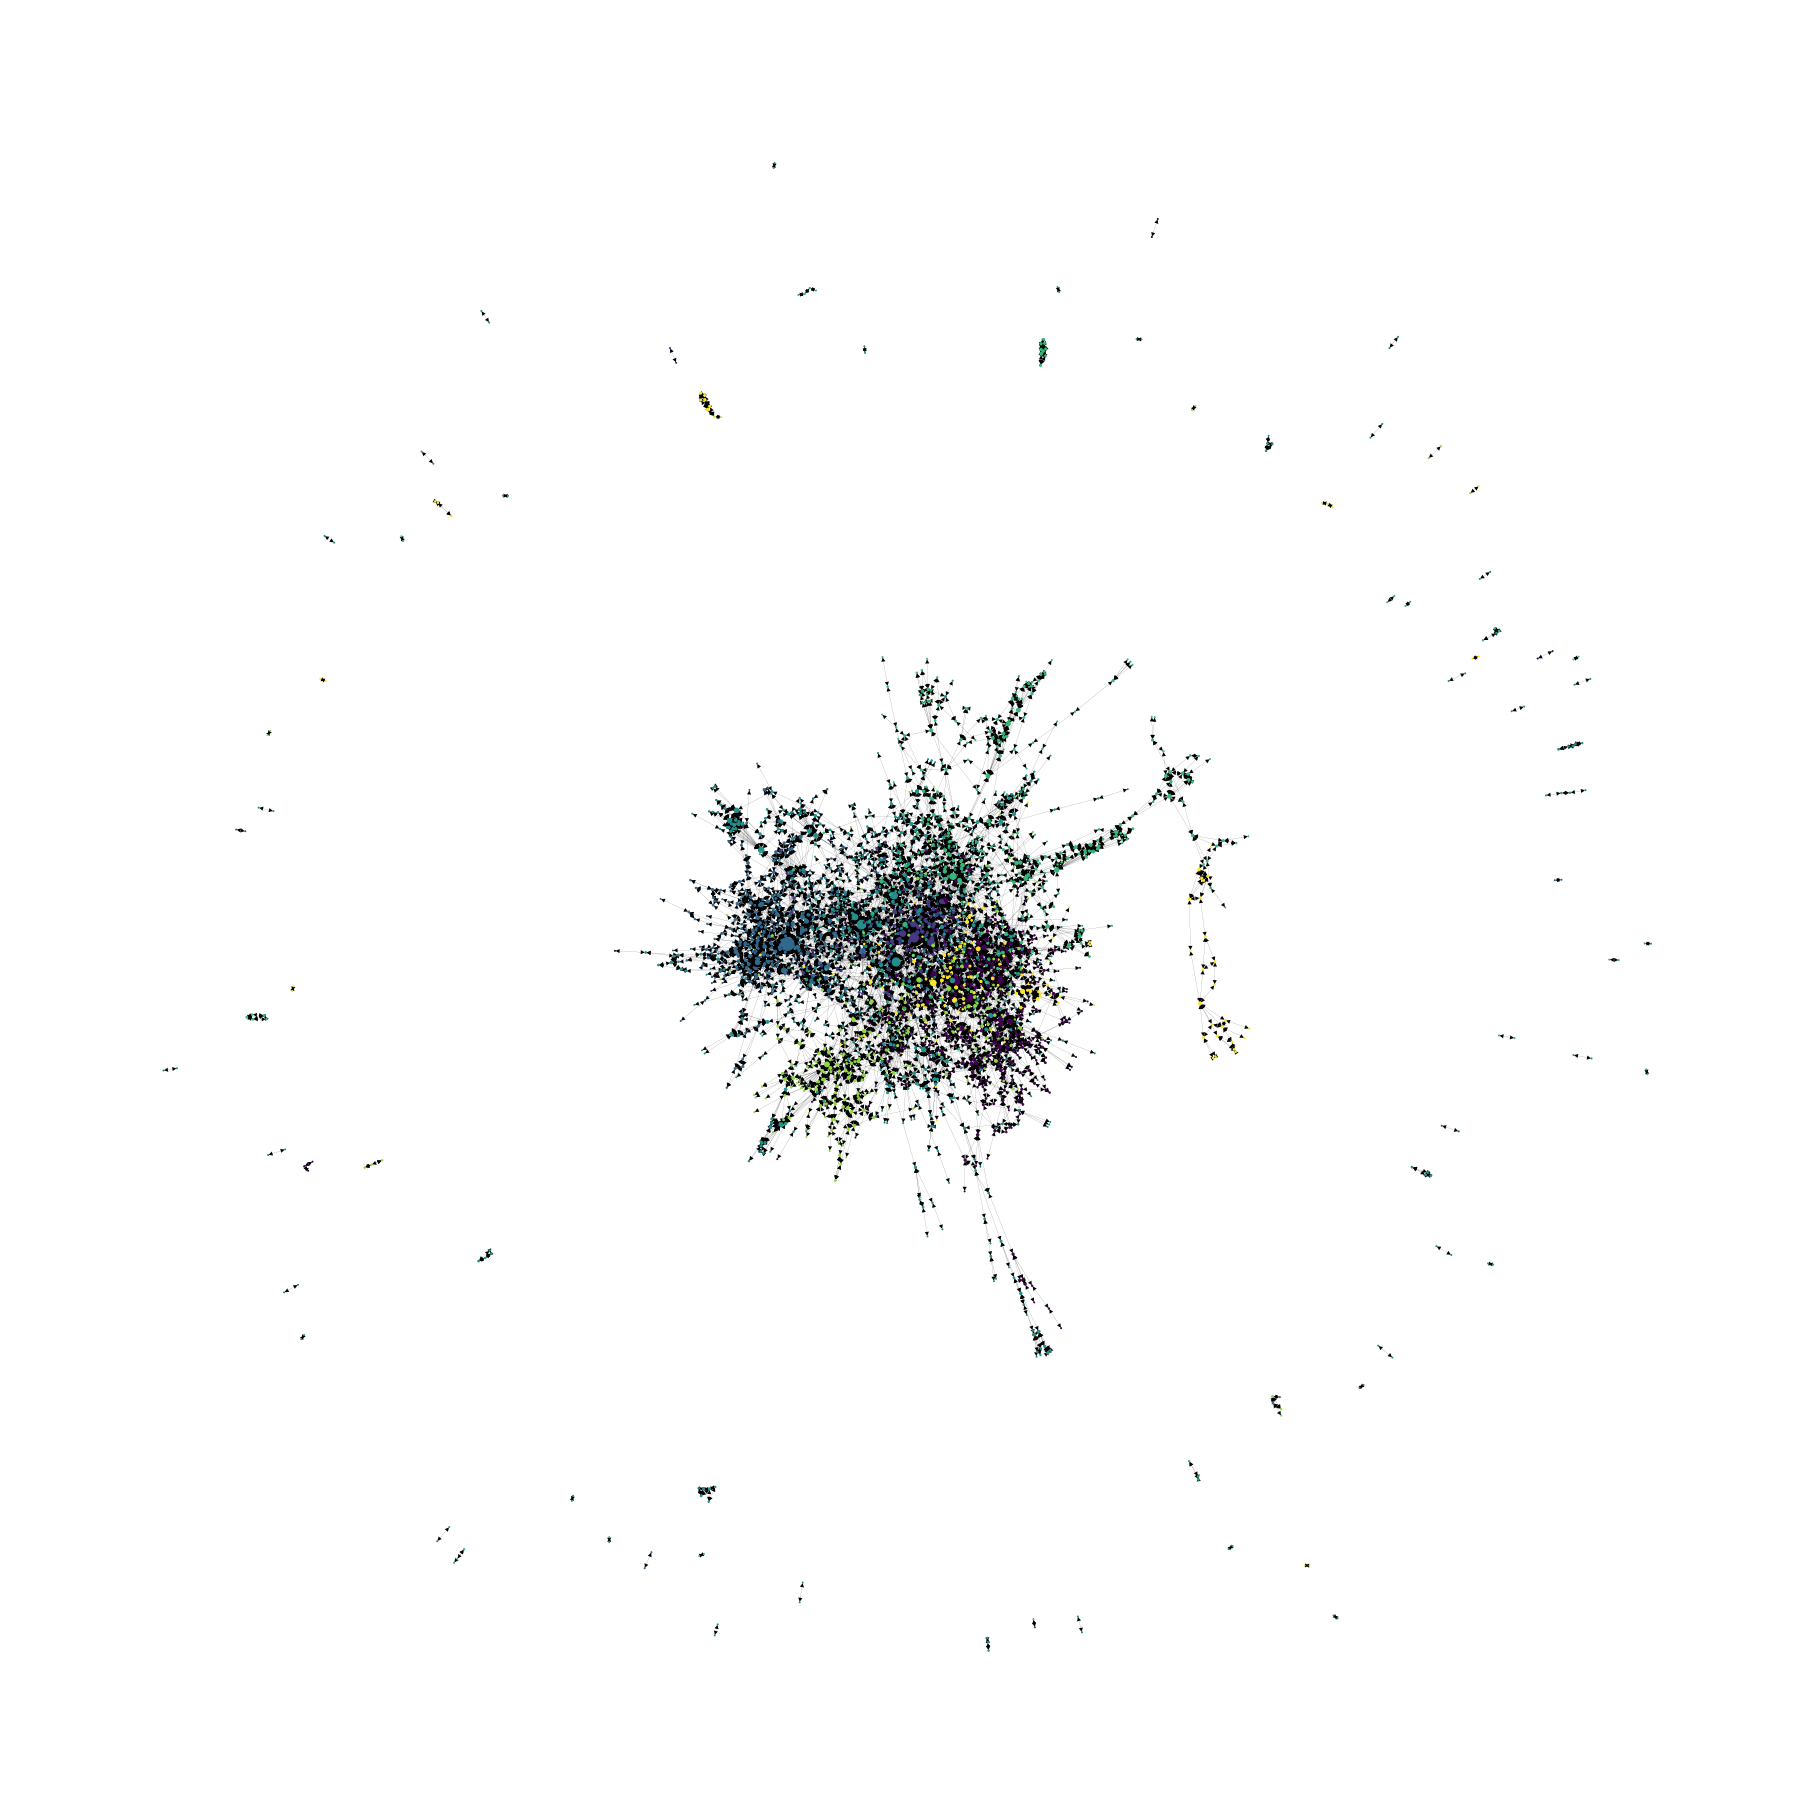

In [ ]:
plt.figure(1,figsize=(25,25)) 
nx.draw(g1.to_networkx(), alpha = 1, node_size = g1.in_degrees(), node_color = g1.ndata['label'], width=0.05)
plt.show()

### Generated

In [38]:
g_synth_list = gen_synthetic_graph_list(g1,k=5,extreme_scale = 10)

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


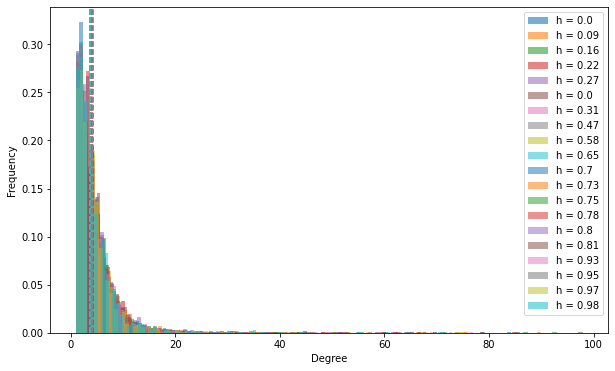

In [39]:
plot_degree_distribution_comparison(g_synth_list)

In [25]:
graph_summary(g_synth_list)

==================================================(GRAPH 1)==================================================
Eigenvalues:  [-2.4148178, -1.4366654, -1.1544414, -1.1246276, 0.5374442, 0.94264823, 4.6504602]
Leading Eigenvalue:  4.650460243225098
Mean Degree:  4.093426704406738
Class Dist:  [0.12961595 0.08013294 0.15435746 0.30206794 0.15731166 0.11004432
 0.06646972]
Edge Homophily:  0.0
Class Normalised Homophily:  0.0
==================================================(GRAPH 2)==================================================
Eigenvalues:  [-0.53711176, 0.18747304, 0.2711196, 0.7074434, 1.5811495, 1.9960306, 4.358428]
Leading Eigenvalue:  4.358428001403809
Mean Degree:  4.0321269035339355
Class Dist:  [0.12961595 0.08013294 0.15435746 0.30206794 0.15731166 0.11004432
 0.06646972]
Edge Homophily:  0.3008516728878021
Class Normalised Homophily:  0.3202098608016968
==================================================(GRAPH 3)==================================================
Eigenvalues:

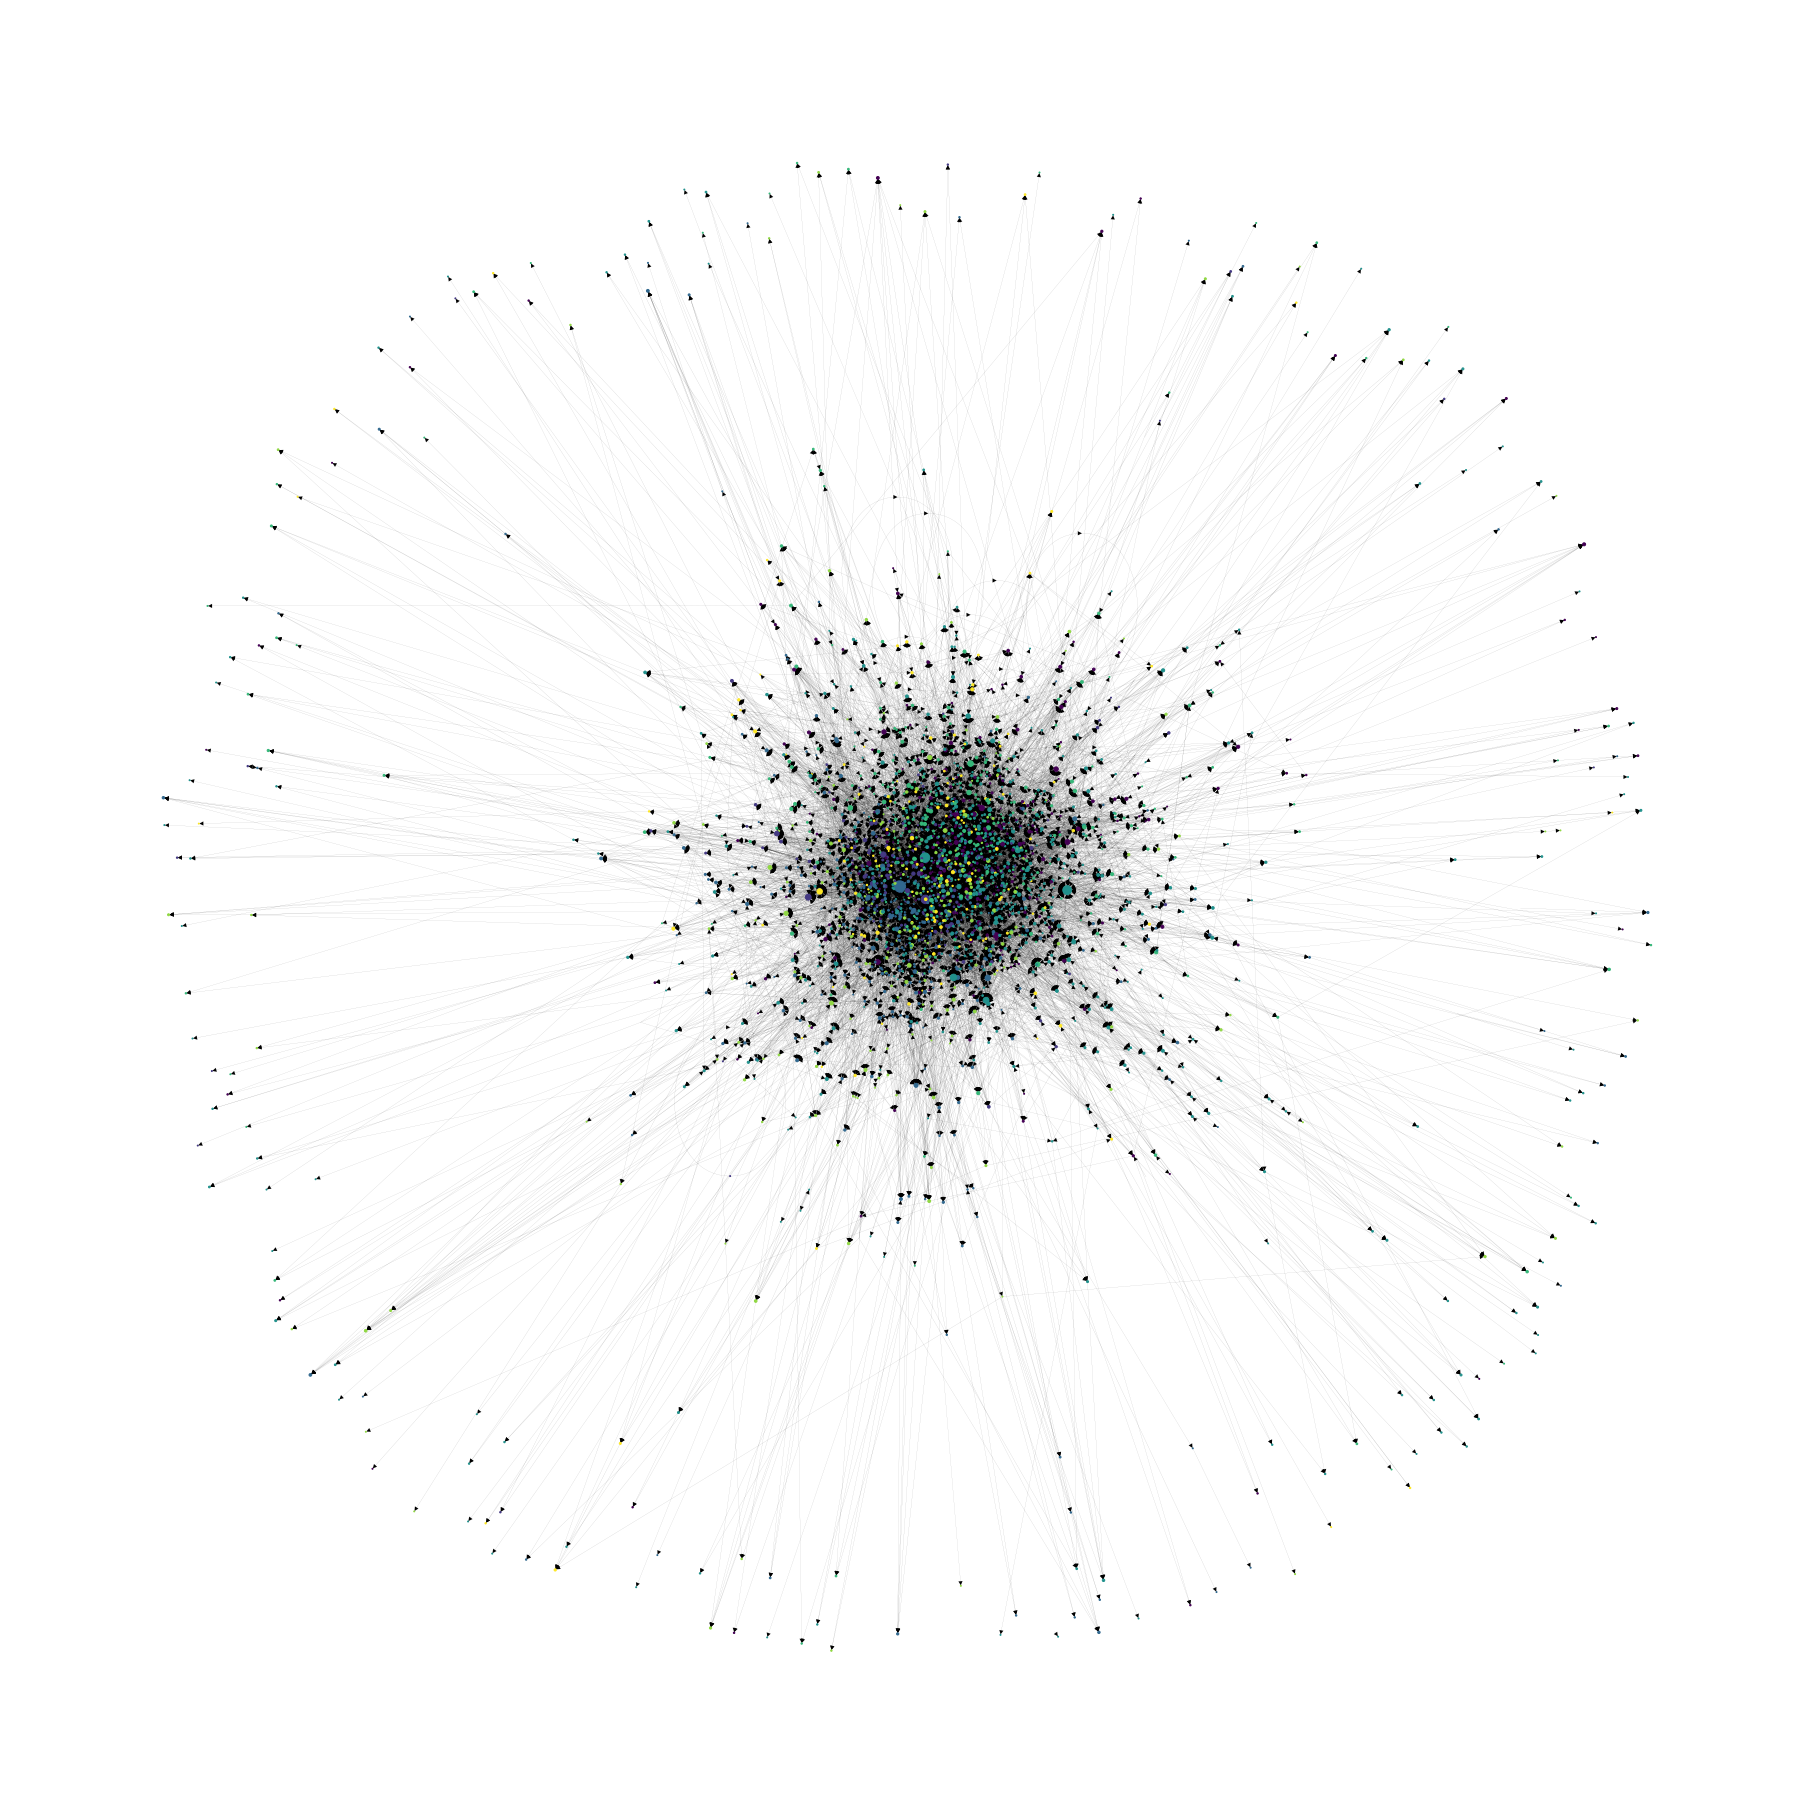

In [27]:
plt.figure(1,figsize=(25,25))
g = g_synth_list[-2]
nx.draw(g.to_networkx(), alpha = 1, node_size = g.in_degrees(), node_color = g.ndata['label'], width=0.05)
plt.show()

## Graph Summaries

In [28]:
graph_summary([g0_homo,g0_hetero,g1,g2,g3,g4,g5])

==================================================(GRAPH 1)==================================================
Eigenvalues:  [5.0, 6.999999, 6.999999, 6.999999, 8.0, 9.0, 9.0, 10.999999, 11.999998, 15.0]
Leading Eigenvalue:  15.0
Mean Degree:  9.779999732971191
Class Dist:  [0.06 0.12 0.13 0.08 0.1  0.1  0.09 0.08 0.08 0.16]
Edge Homophily:  1.0
Class Normalised Homophily:  1.0
==================================================(GRAPH 2)==================================================
Eigenvalues:  [-15.000003, -13.606925, -11.437759, -10.000004, -10.000001, -9.235222, -8.252684, -6.346469, -5.21713, 89.0962]
Leading Eigenvalue:  89.09619903564453
Mean Degree:  89.0
Class Dist:  [0.15 0.08 0.09 0.1  0.06 0.1  0.1  0.05 0.12 0.15]
Edge Homophily:  0.0
Class Normalised Homophily:  0.0
==================================================(GRAPH 3)==================================================
Eigenvalues:  [2.5097375, 2.637981, 2.7183459, 3.0540445, 3.5139594, 3.7276642, 4.188745]
Leadin

## Run Simuations

In [40]:
g1_list,acc_list1,mean_spl_list1,mean_intra_spl_list1 = run_full_simulation(g1,k=25,extreme_scale = 10)

Generating synthetic graphs...


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Testing GNN performance...


100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


Calculating geodesics...


100%|██████████| 100/100 [49:39<00:00, 29.79s/it]


In [41]:
torch.save(g1_list,'g1_list')
torch.save(mean_spl_list1,'mean_spl_list1')
torch.save(mean_intra_spl_list1,'mean_intra_spl_list1')
torch.save(acc_list1,'acc_list1')

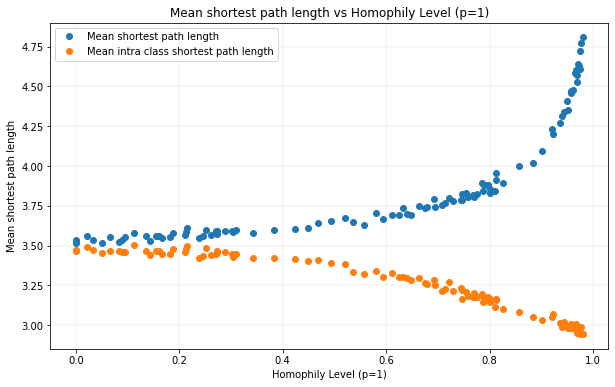

In [42]:
plot_mean_spl_comparison(g1_list,mean_spl_list1,mean_intra_spl_list1,p=1)

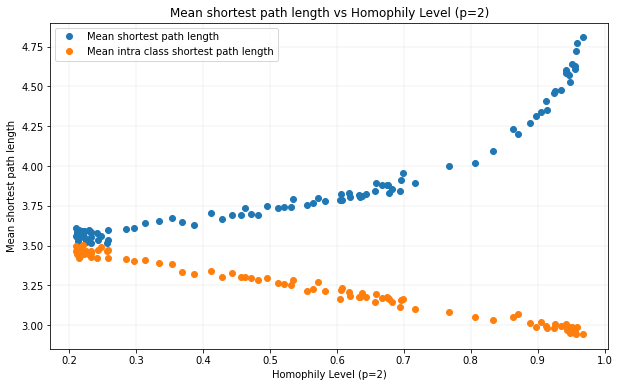

In [46]:
plot_mean_spl_comparison(g1_list,mean_spl_list1,mean_intra_spl_list1,p=2)

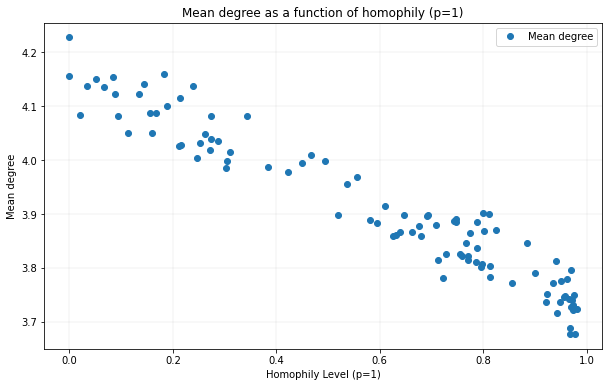

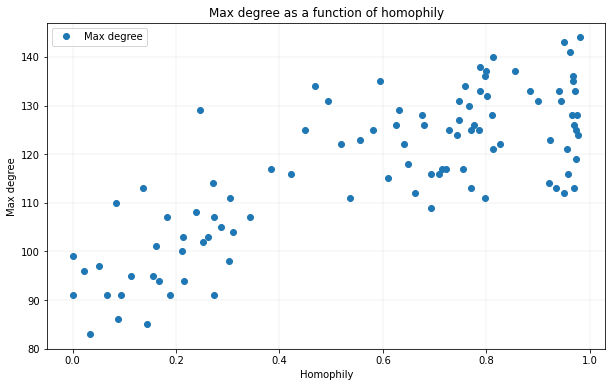

In [43]:
plot_homophily_degree(g1_list)

In [ ]:
g1_list = torch.load('g1_list')
mean_spl_list1 = torch.load('mean_spl_list1')
mean_intra_spl_list1 = torch.load('mean_intra_spl_list1')
acc_list1 = torch.load('acc_list1')



## GNN vs Homophily

In [44]:
h_list1 = calculate_homophily(g1_list)


100%|██████████| 100/100 [00:01<00:00, 59.81it/s]


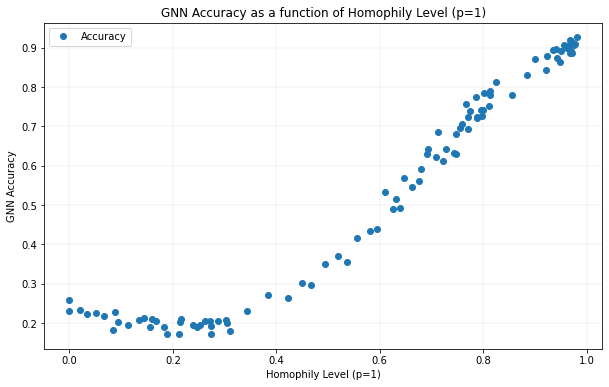

In [55]:
plot_test_gnn_vs_homophily(g1_list,acc_list1)

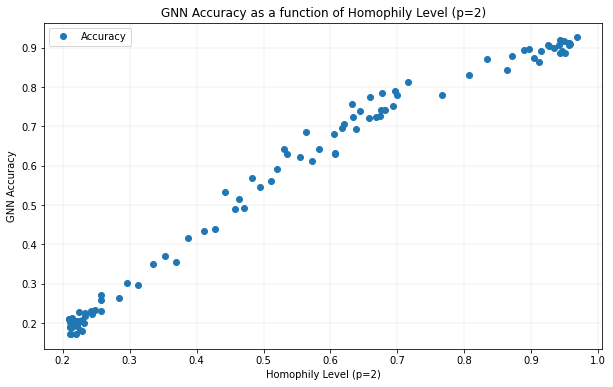

In [56]:
plot_test_gnn_vs_homophily(g1_list,acc_list1,p=2)

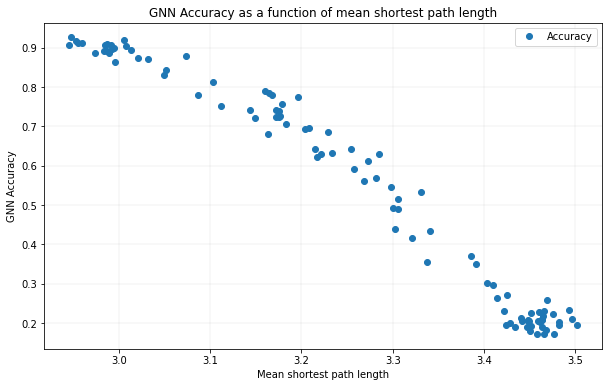

In [50]:
plot_test_gnn_vs_spl(mean_intra_spl_list1,acc_list1)